In [ ]:
"""  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets
<https://arxiv.org/pdf/2101.08692.pdf>`_"
"""

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# https://github.com/TylerYep/torchinfo/blob/e93aa4f405e86dca96f2da63cf019d4e2b4ce48c/torchinfo/torchinfo.py#L317

In [4]:
# SPP:

# # Average Channel Squared Mean:
# # np.mean(np.mean(y, axis=[0, 1, 2]) ** 2)
# # • Average Channel Variance:
# # np.mean(np.var(y, axis=[0, 1, 2]))
# # • Residual Average Channel Variance:
# # np.mean(np.var(f(x), axis=[0, 1, 2])) # y = f(x) + identity
    

# SPP for my ResNet from torch

In [5]:
from models_module.my_models import ResNet, ResBlock, ResNetLayer
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

model = ResNet(1, 10, [128], [2])

In [6]:
# old code example of filtering

# ResNet_signal_propagation = []

# def hook(self, input, output) -> None:
#     # cache signals from ResBlocks
#     ResNet_signal_propagation.append(output.detach().numpy())

# def get_all_layers(net, instances_for_hook=(), instances_with_nested_objects=[]): 
#     if not isinstance(instances_for_hook, tuple):
#         instances_for_hook = tuple(instances_for_hook)        
    
#     # add nn.Sequential, nn.ModuleList to tuple of instances_with_nested_objects
#     for instance in (nn.Sequential, nn.ModuleList):
#         if instance not in instances_with_nested_objects:
#             if not isinstance(instances_with_nested_objects, list):
#                 instances_with_nested_objects = list(instances_with_nested_objects)
#             instances_with_nested_objects.append(instance)
#     if not isinstance(instances_with_nested_objects, tuple):
#         instances_with_nested_objects = tuple(instances_with_nested_objects)
    
#     for name, layer in net._modules.items():
#         if isinstance(layer, instances_with_nested_objects):
#             # get all nested objects
#             get_all_layers(layer, instances_for_hook, instances_with_nested_objects)
#         elif isinstance(layer, instances_for_hook):
#             # hook preferable layers outputs
#             layer.register_forward_hook(hook)

# get_all_layers(net, instances_for_hook=[ResBlock], instances_with_nested_objects=[ResNetLayer])
# out = net(torch.randn(1,1,28,28))

In [7]:
class ModelHooksControllerForSPP:
    """ Manipulations with forward hooks of all network units for signal propagation plot."""
    def __init__(self, model):    
        self.statistics = {
            'Average Channel Squared Mean': [], 
            'Average Channel Variance': []
        }
        self.instances = []
        self.registered_hooks = []
        self.register_hook(model)
        
    def register_hook(self, module):
        # Check is it the lowest level
        submodules_amount =  sum(1 for _ in module.modules())
        if submodules_amount == 1: 
            self.registered_hooks.append(module.register_forward_hook(self.signal_propagation_hook))

        # Go deeper in network
        for child in module.children():
            self.register_hook(child)
        
    def signal_propagation_hook(self, module, input, output):
        # Cache signal statistics and module instance for each network unit
        instance = module.__class__.__name__
        avg_ch_squared_mean = torch.mean(torch.mean(output, axis=1) ** 2).detach().numpy()
        avg_ch_var =  torch.mean(torch.var(output, axis=1)).detach().numpy()
        
        self.statistics['Average Channel Squared Mean'].append(avg_ch_squared_mean)
        self.statistics['Average Channel Variance'].append(avg_ch_var)
        self.instances.append(instance)

    
    def remove_hooks(self):
        for hook in self.registered_hooks:
            hook.remove()

class SPP:
    """ Signal Propagation Plots"""   
    def __init__(self, model, image_shape, batch_size=3, show_plots=True):
        self.statistics = None
        self.modules_instances = None
        self.SPP_info(model, image_shape, batch_size, show_plots)
        
    def SPP_info(self, model, image_shape, batch_size=3, show_plots=True):
        """Signal propagation info.

        Collect signal propagation statistics and show signal propagation plots.

        """
        if len(image_shape) != 3:
            raise ValueError("Parameter image_shape must be a sequence of 3 elements (C, H, W)")
        image_shape = (batch_size, *image_shape)

        # Register signal propagation statistics and modules instances for all network units
        try:
            hooks_controller = ModelHooksControllerForSPP(model)
            _ = model(torch.randn(image_shape))
        finally:
            hooks_controller.remove_hooks()        
        self.statistics = hooks_controller.statistics
        self.modules_instances = hooks_controller.instances

        # Show signal propagation plots
        if show_plots:
            self.show_SPP_graphs()
    
    def show_SPP_graphs(self):
        """ Plot graphs of signal propagation statistics over networks units. """
        fig, axes = plt.subplots(1, len(self.statistics), figsize=(15, 5))
        for (ax, (title, data)) in zip(axes, self.statistics.items()):
            x = range(len(data))
            ax.plot(x, data)
            ax.set_title(title+" over network units", fontsize=14)
            ax.set_xlabel("Number of network unit", fontsize=12)
            ax.set_ylabel(title, fontsize=12)
        fig.show()

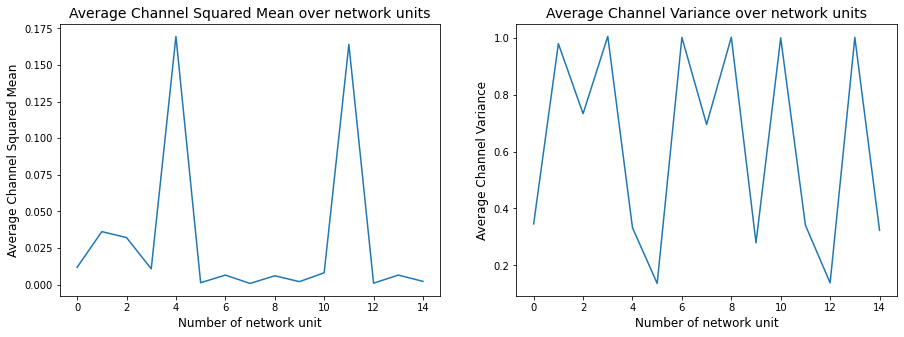

In [8]:
sp_info = SPP(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)

In [9]:
_ = model(torch.randn(3, 1, 28, 28))

In [10]:
print(len(sp_info.statistics['Average Channel Squared Mean'])) # must be 15
print(sp_info.modules_instances)

15
['Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Linear']


# SPP for ResNet from batchflow

In [11]:
import sys
sys.path.append("..")

In [12]:
from batchflow.models.torch import ResNet

In [13]:
num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet(model_config).model

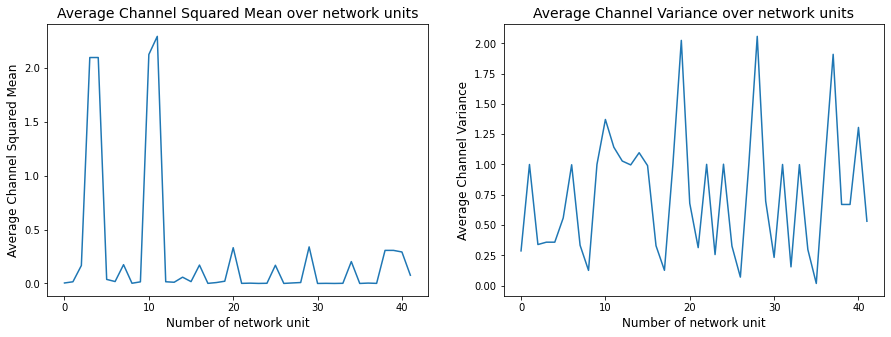

In [14]:
sp_info = SPP(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)

In [15]:
print(len(sp_info.statistics['Average Channel Squared Mean'])) # must be 42
print(sp_info.modules_instances)

42
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'AdaptiveAvgPool2d', 'Dropout', 'Linear']


# Third Model

## pre-activated

In [16]:
from batchflow.models.torch import ResNet34

num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu',
    'body/encoder/blocks/layout': 'nacnac',
    'body/encoder/blocks/op': '+'
}

model = ResNet34(model_config).model # ask about ResNet50 config

138
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Conv2d', 'BatchNorm2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Conv2d', 'BatchNorm2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'Combine', 'Identity', 'BatchNorm2d', 'ReLU'

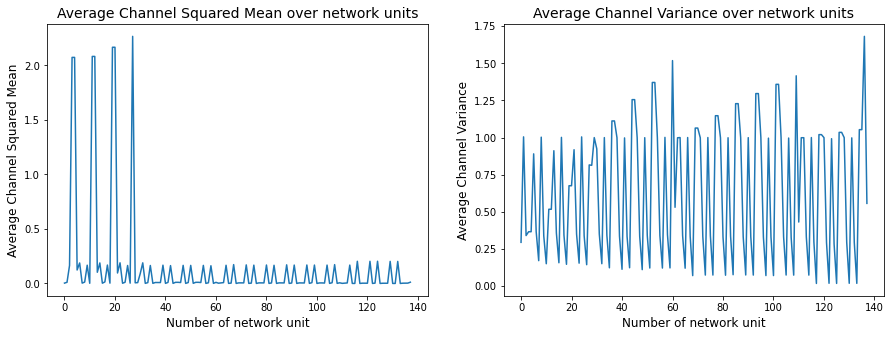

In [17]:
sp_info = SPP(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)
print(len(sp_info.statistics['Average Channel Squared Mean']))
print(sp_info.modules_instances)

## post-activated

In [18]:
from batchflow.models.torch import ResNet34

num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet34(model_config).model # ask about ResNet50 config

138
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Identity', 'Conv2d', 'BatchNorm2

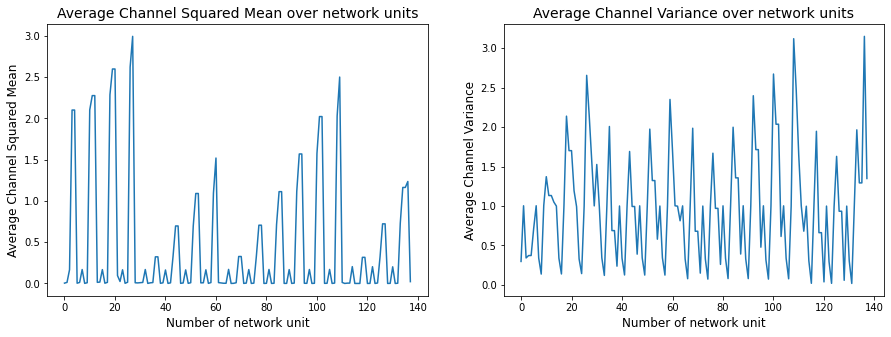

In [19]:
sp_info = SPP(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)
print(len(sp_info.statistics['Average Channel Squared Mean']))
print(sp_info.modules_instances)